# Activation Functions, Gradient Flow and Dead Neurons - Worked Example

<hr style="border:2px solid gray">

# Index: <a id='index'></a>
1. [Introduction and Setup](#intro)
1. [Common Activation Functions](#common-activation-functions)
1. [Visualising Activation Functions](#visualising-act)
1. [Fashion MNIST Dataset](#fashion)
1. [Gradient Flow](#gradient-flow)
1. [Training a Model](#training-a-model)
1. [Dead Neurons](#dead-neurons)
1. [Conclusion](#conclusion)
1. [Appendix](#appendix)
    1. [Backpropagation with Matrices](#matrix_app)
    2. [Cross-Entropy](#cross)
    3. [Activation Functions Overview](#act_fn_app)

This notebook is heavily based on one from Universitaet van Amsterdam's deep learning course written by Phillip Lippe.

You can see his original filled notebook at:
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial3/Activation_Functions.ipynb)

**Pre-trained models:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial3)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/1sFpZUpDJVjiYEvIqISqfkFizfsTnPf4s?usp=sharing)   

<hr style="border:2px solid gray">

# Introduction and Setup [^](#index) <a id='intro'></a>

Last week, you were introduced to the basics of neural networks. In this tutorial we will focus on the **activation function**, which characterises the response at each neuron. 

As discussed previously in the Single Neuron Notebook,  activation functions are a crucial part of deep learning models because they can add **non-linearity** to the network. Without non-linearity, increasing the number of layers will not effect our network's performance - the output would always be a linear combination of the input variables， and so could have been achieved with just a single layer.

There is a great variety of activation functions in the literature, and some are more beneficial than others.
The goal of this tutorial is to show the importance of choosing a good activation function (and how to do so), and what problems might occur if we do not.

Before we start, we should import our standard libraries and set up basic functions:

In [2]:
## Standard libraries
import os
import json
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

To make our training reproducible, we will set a seed for the random numbers that we generate from Torch and numPy.

If you are using a department provided laptop, or many other types of commercial machines, you will not have access to a GPU. GPUs can increase the speed of the training process and thus are very important when working with more complex models, however simply using a CPU in this course will be **sufficient**.

_Unlike the CPU, the same seed on different GPU architectures can give different results. All the prebuilt models linked above here have been trained on an NVIDIA GTX1080Ti._

The following cell also defines two file paths: DATASET_PATH and CHECKPOINT_PATH. The dataset path is the directory where we will download datasets used in the notebooks. It is recommended to store all datasets from PyTorch in one joined directory to prevent duplicate downloads. The checkpoint path is the directory where we will store the trained model weights and additional files. The files required will be automatically downloaded. 

In [3]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial3"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


The following cell downloads all pretrained models we will use in this notebook. These are copies from Philip Lippe's course. The files are stored in a separate [repository](https://github.com/pjdunne/saved_models). Please let me (Patrick) know if an error occurs so it can be fixed for all students.

In [4]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/pjdunne/saved_models/main/tutorial3/"
# Files to download
pretrained_files = ["FashionMNIST_elu.config", "FashionMNIST_elu.tar", 
                    "FashionMNIST_leakyrelu.config", "FashionMNIST_leakyrelu.tar",
                    "FashionMNIST_relu.config", "FashionMNIST_relu.tar",
                    "FashionMNIST_sigmoid.config", "FashionMNIST_sigmoid.tar",
                    "FashionMNIST_swish.config", "FashionMNIST_swish.tar",
                    "FashionMNIST_tanh.config", "FashionMNIST_tanh.tar"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

<hr style="border:2px solid gray">

# Common Activation Functions [^](#index) <a id='common-activation-functions'></a>

We will first implement some common activation functions, writing our own functions to gain a better understanding and insight into how they operate. Most of these functions can also be found in the `torch.nn` package (see the [documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for an overview).

_The following code uses Object Orientated Programming (OOP). If you are unfamiliar or out of practice with OOP, you may wish to read the 2nd Bootcamp Notebook for some guidance._


To make it easier to compare various activation functions, we will start by defining a base class from which all our future modules will inherit:

In [5]:
class ActivationFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

Every activation function will be an `nn.Module` so that we can integrate them nicely in a network. We will use the `config` dictionary to store adjustable parameters for some activation functions.

Next, we will implement two of the "oldest" activation functions that are still commonly used for various tasks: sigmoid and tanh. Both the sigmoid and tanh activation can be also found as PyTorch functions (`torch.sigmoid`, `torch.tanh`) or as modules (`nn.Sigmoid`, `nn.Tanh`). 

<div style="background-color:#C2F5DD">
    
### Exercise
    
Below, you should write the code for the `forward` function of two activation functions. 
     
If you are unsure of the form of either of the two functions, feel free to look them up online.

In [6]:
class Sigmoid(ActivationFunction):
    
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

##############################   
    
class Tanh(ActivationFunction):
    
    def forward(self, x):
        x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
        return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)
    
##############################

### Alternative Activation Functions

Another popular activation function that has allowed the training of deeper networks is the **Rectified Linear Unit (ReLU)**. This function returns the input for inputs greater than 0, and returns 0 for inputs less than or equal to 0. Despite its simplicity, ReLU has one major benefit compared to sigmoid and tanh: a strong, stable gradient for a large range of values.

Based on this idea, many variations of ReLU have been proposed. We will implement the following three:

**LeakyReLU:** In the negative region of the input space, LeakyReLU has the form of a linear function with a small gradient (alpha), rather than just being 0. This non-zero gradient means that gradients can also 'flow' in this part of the input. We'll see what this means later.

**ELU:** This is similar to the leaky ReLU but replaces the function in the negative input space with an exponential decay.

**Swish:** This is the most recently proposed of these activation functions, and is actually the result of a large experiment with the purpose of finding the "optimal" activation function. Swish returns the input multiplied by the sigmoid of the input.
Compared to the other activation functions, Swish is both smooth and non-monotonic (i.e. Swish's gradient  has a change of sign). Swish is designed to solve a problem called 'dead neurons' which can occur with standard ReLU. We'll see what this is later, but it is a particular problem with deep networks.
If interested, a more detailed discussion of the benefits of Swish can be found in [this paper](https://arxiv.org/abs/1710.05941) [1].

<div style="background-color:#C2F5DD">
    
### Exercise
    
Given the desciptions above, implement these four activation functions.

In [7]:
##############################

class ReLU(ActivationFunction):
    
    def forward(self, x):
        return x * (x > 0).float()

##############################

class LeakyReLU(ActivationFunction):
    
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha
        
    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

##############################
    
class ELU(ActivationFunction):
    
    def forward(self, x):
        return torch.where(x > 0, x, torch.exp(x)-1)

##############################
    
class Swish(ActivationFunction):
    
    def forward(self, x):
        return x * torch.sigmoid(x)
    
##############################

We can summarise all our activation functions in a dictionary, which maps the name of the function to the class object. If you wish to implement a new activation function, add it to this dictionary to include it in future comparisons.

In [8]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
    "elu": ELU,
    "swish": Swish
}

<hr style="border:2px solid gray">

# Visualising Activation Functions [^](#index) <a id='visualising-act'></a>

To understand what each activation function actually does, it may be useful to visualise both the function and its **gradient**. Understanding the gradient of the activation function is crucial for optimising the neural network. 

PyTorch allows us to compute the gradients by calling the `backward` function. The cell below demonstrates how this can be implemented. For more information on the backwards and how it operates function, please see the Appendix section [PyTorch backwards() Function](#backwards_app).



In [9]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.
    
    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor. 
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"

We can now visualise all our activation functions including their gradients.

<div style="background-color:#C2F5DD">
    
### Exercise

Complete the following functions in order to generate nice plots of the activation functions:

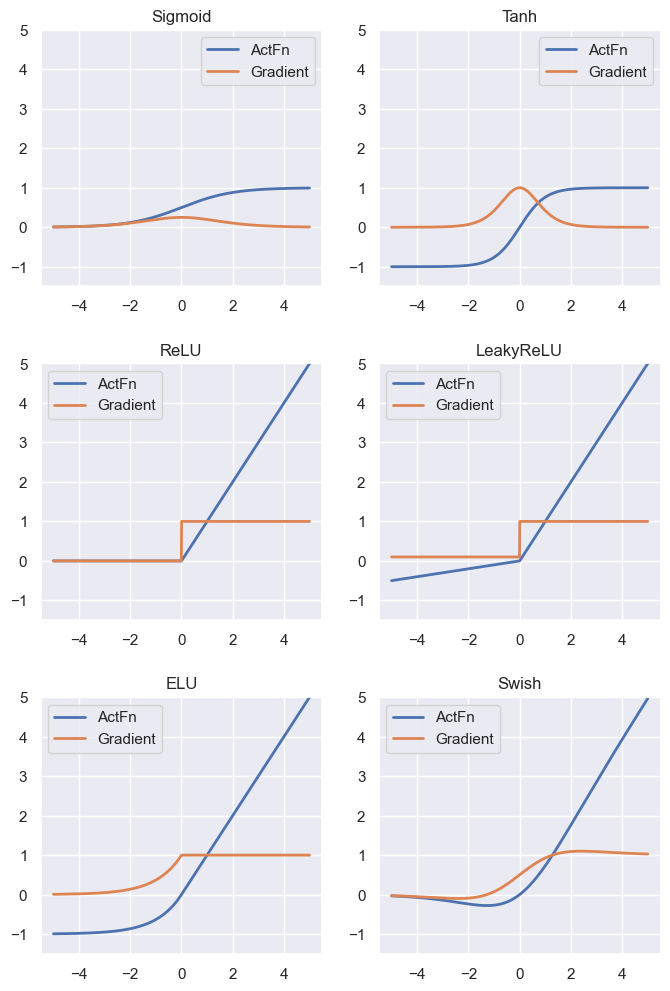

In [10]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

<hr style="border:2px solid gray">

# Fashion MNIST Dataset [^](#index) <a id='fashion'></a>

To see the impact each activation function has on training our neural network, we will look at a simple example NN trained on [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist).

FashionMNIST is a more complex version of MNIST and contains black-and-white images of clothes instead of digits. The 10 classes include trousers, coats, shoes, bags and more. 

To load this dataset, we will make use of the PyTorch package `torchvision` ([documentation](https://pytorch.org/docs/stable/torchvision/index.html)). The `torchvision` package consists of popular datasets, model architectures, and common image transformations for computer vision. We will use the package for many of the notebooks in this course to simplify our dataset handling. 

FashionMNIST already has the training and test sets separated but we need to split the training and validation sets ourselves. Below we load in the dataset:

In [11]:
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them in the range -1 to 1

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 37.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 1.11MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 19.7MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.33MB/s]


<div style="background-color:#C2F5DD">

### Exercise
    
Visualize a few of the MNIST images to get an impression of the data.

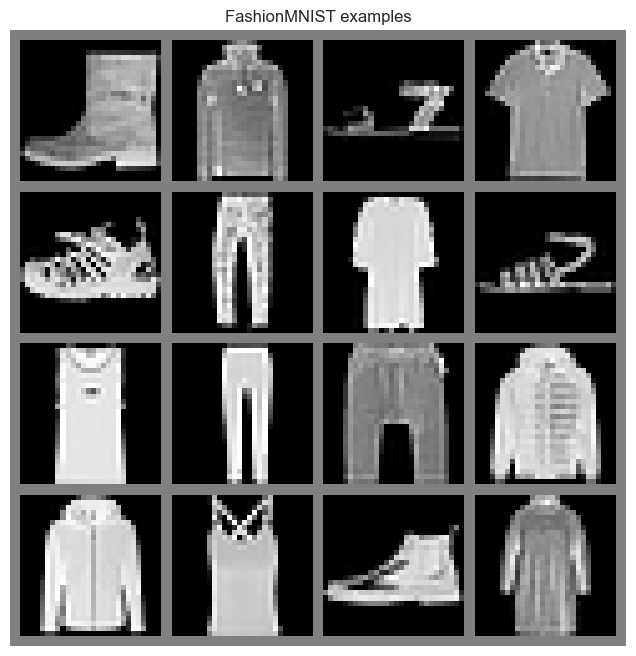

In [12]:
exmp_imgs = [train_set[i][0] for i in range(16)]
# Organize the images into a grid for nicer visualization
img_grid = torchvision.utils.make_grid(torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### Neural Network Setup

The code below contains the framework to implement the required network: we must view the Fashion MNIST images as 1D tensors and then push them through a sequence of linear layers and a specified activation function. 

I've given the function signature below. Feel free to experiment with other network architectures.

<div style="background-color:#C2F5DD">
    
### Exercise

Complete the cell below by adding the code required to create the hidden layers.
   

In [13]:
class BaseNetwork(nn.Module):
    
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()
        
        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers) # nn.Sequential summarizes a list of modules into a single module, applying them in sequence
        
        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes} 
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # Reshape images to a flat vector
        out = self.layers(x)
        return out    

We also add functions for loading and saving the model. The hyperparameters are stored in a configuration file (simple json file):

In [14]:
def _get_config_file(model_path, model_name):
    # Name of the file for storing hyperparameter details
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    # Name of the file for storing network parameters
    return os.path.join(model_path, model_name + ".tar")

def load_model(model_path, model_name, net=None):
    """
    Loads a saved model from disk.
    
    Inputs:
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
        net - (Optional) If given, the state dict is loaded into this model. Otherwise, a new model is created.
    """
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        act_fn = act_fn_by_name[act_fn_name](**config_dict.pop("act_fn"))
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file, map_location=device))
    return net
    
def save_model(model, model_path, model_name):
    """
    Given a model, we save the state_dict and hyperparameters.
    
    Inputs:
        model - Network object to save parameters from
        model_path - Path of the checkpoint directory
        model_name - Name of the model (str)
    """
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

<hr style="border:2px solid gray">

# Gradient flow [^](#index)  <a id='gradient-flow'></a>

An important aspect of neural network training are the **gradients** of each parameter (i.e. the partial derivative of the loss function wrt that parameter). Each activation function results in different gradients, and it is important to understand what these differences mean for the training process.

<div style="background-color:#C2F5DD">
    
### Exercise

Plot a freshly initialised network and measure the gradients for each parameter at the activation function layers of your model for a batch of 256 images. This should give you a feeling about how each activation function influences the gradients.

For your loss function, use **cross entropy** (please read the Appendix section [Cross-Entropy](#cross) or see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html)).

In [15]:
def visualize_gradients(net, color="C0"):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=256, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Pass one batch through the network, and calculate the gradients for the weights
    
    net.zero_grad()
    preds =net(imgs)
    loss =F.cross_entropy(preds, labels)
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    
    grads = {name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name}
    net.zero_grad()
    
    ## Plotting
    columns = len(grads)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3.5, 2.5))
    fig_index = 0
    for key in grads:
        key_ax = ax[fig_index%columns]
        sns.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)  
        key_ax.set_title(str(key))
        key_ax.set_xlabel("Grad magnitude")
        fig_index += 1
    fig.suptitle(f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05)
    fig.subplots_adjust(wspace=0.45)
    plt.show()
    # The initialisation of the weight parameters can also be crucial to creating an optimal model and avoiding problems with vanishing
    # gradient. By default, PyTorch uses the [Kaiming](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) 
    # initialisation for linear layers optimised for ReLU activations. We could do a whole extra class on initialisation, 
    # but assume for now that the Kaiming initialisation works for all activation functions reasonably well (the Universitet van Amsterdam
    # course has more information on initialisation in [Lecture 4](https://github.com/phlippe/uvadlc_notebooks/tree/master/docs/tutorial_notebooks/tutorial4)).
    plt.close() 

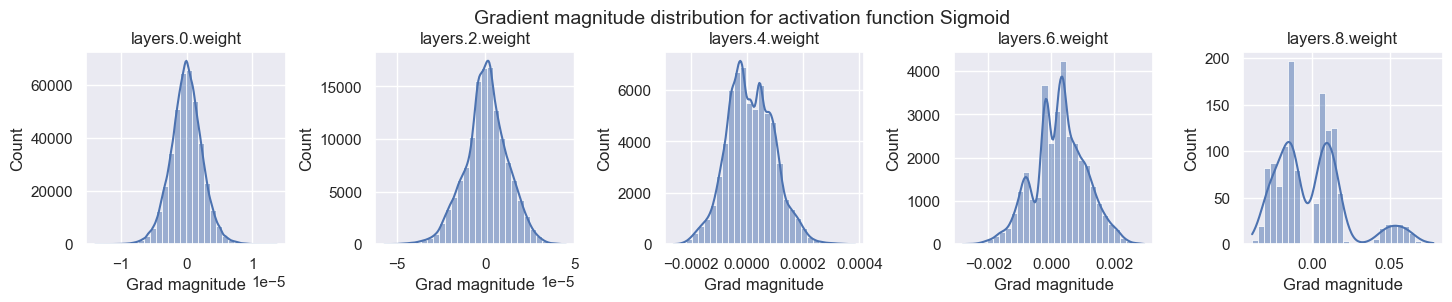

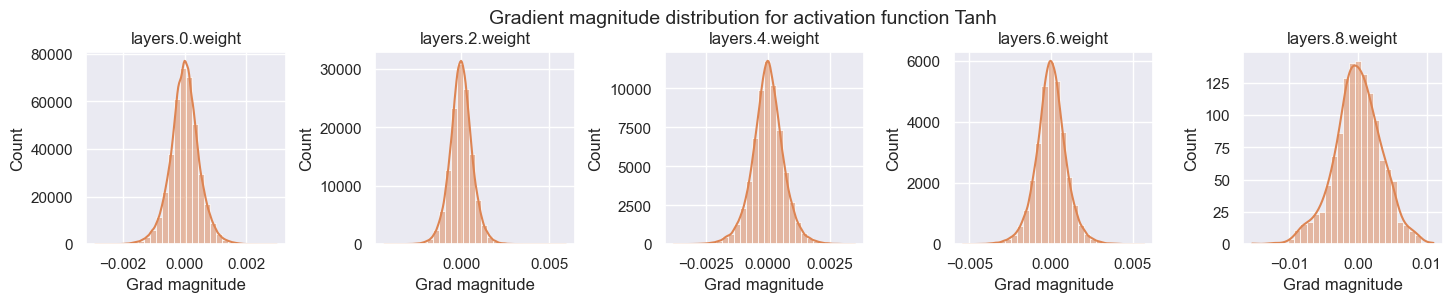

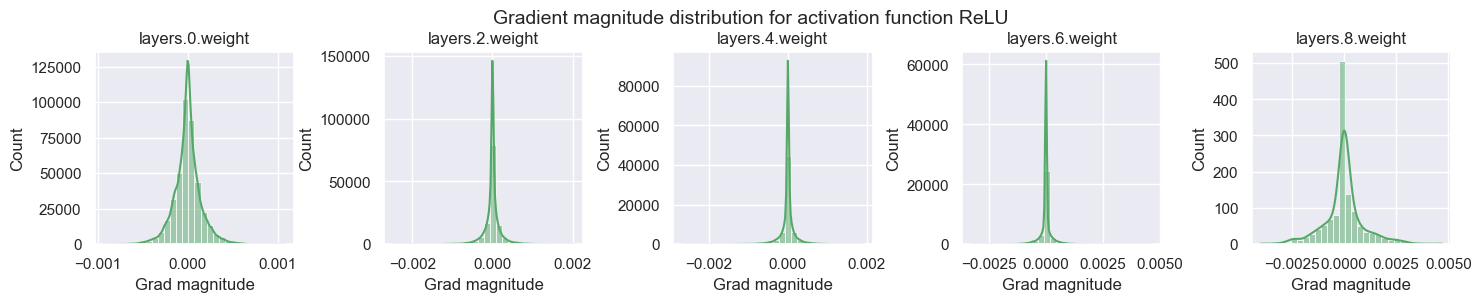

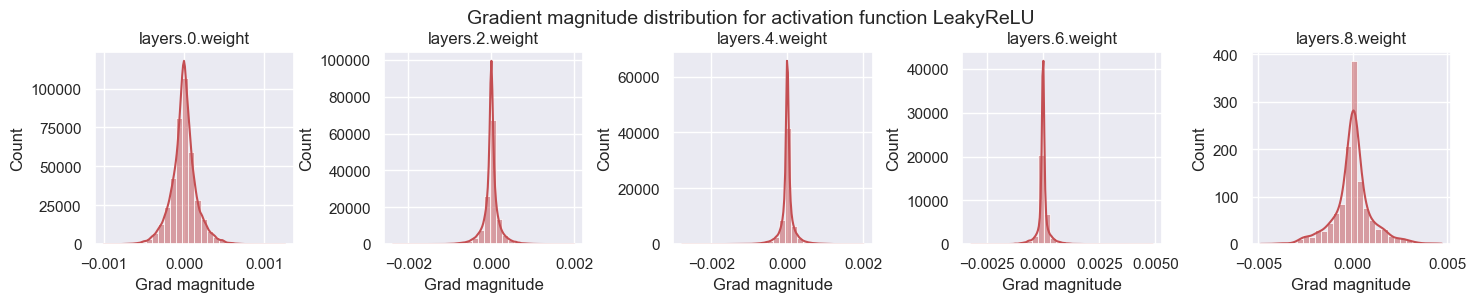

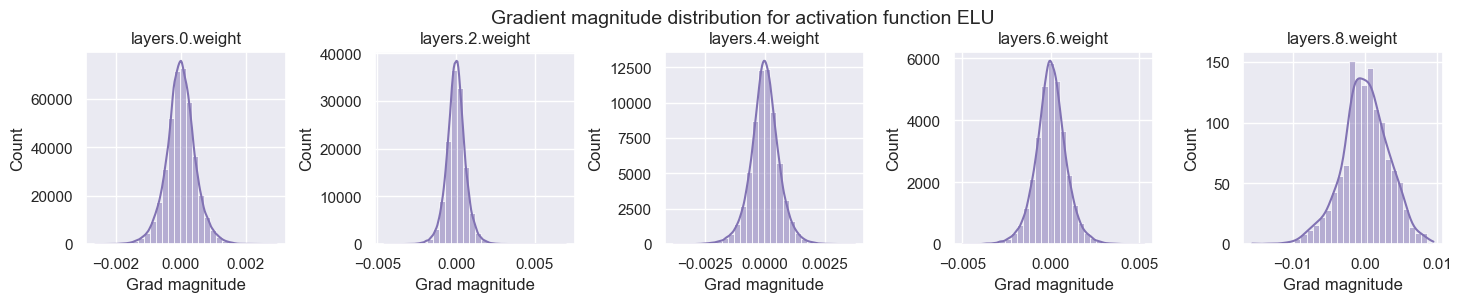

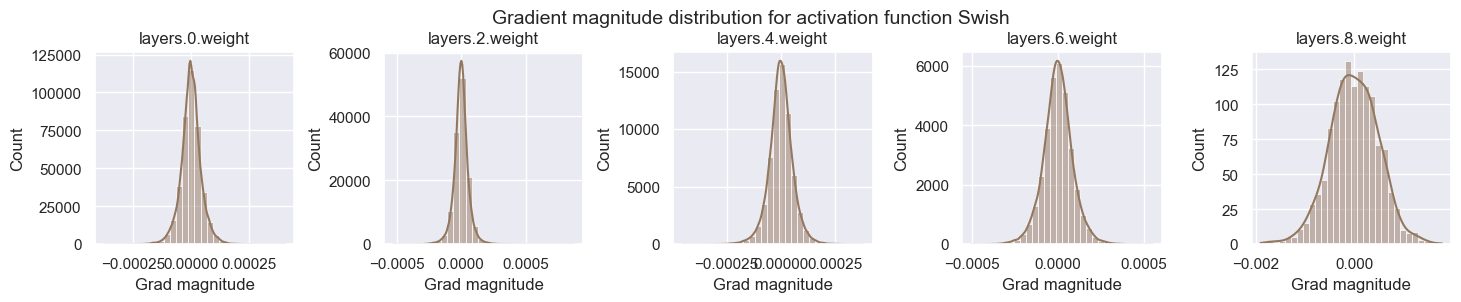

In [16]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
import warnings
warnings.filterwarnings('ignore')
## Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    set_seed(42) # Setting the seed ensures that we have the same weight initialization for each activation function
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    visualize_gradients(net_actfn, color=f"C{i}")
    
#N.b. The number indicating the number of layers refers to both the linear layers and those containing the activation function

To make sense of these plots, we must first understand the principles behind **gradient flow**.

**Gradient flow** describes how activation functions propagate the gradients of the loss function (referred to here as gradients) through the network. First, we should remind ourselves about how a multi-layered NN trains:

1. **Forward Pass:** The input data is fed into the neural network and passes through the successive layers. 
1. **Loss Calculation:** Using a specified loss function, the error of our predicted values compared to the true values is calculated. By training our model, we want to minimise this error.
1. **Backward Pass (Backpropagation):** This is the key concept in gradient flow, and was discussed in more detail in the Neural Networks notebook. 
- Just like in the linear models we considered in ML Basics, we can minimise the loss by moving in the direction of the negative gradient of the loss function. Unlike in linear models, the relationship between loss function and the weights and bias is often not direct (there may be many NN layers with activation function in between).
- To solve this, we calculate the gradients by using the chain rule and moving **backwards** through our network. 
- Consider the image below, where $\phi$ represents our activation function and the term in brackets is $z$ (z will have the same indexing notation as the other terms), as we saw before. From the chain rule, we can calculate the effects of weights in the final layer using:


$$\frac{\partial L}{\partial w^{(2)}_{11}} = \frac{\partial L}{\partial \phi  (z^{(2)} )}
                                              \frac{\partial \phi (z^{(2)})}{\partial z^{(2)}}
                                              \frac{\partial z^{(2)}}{\partial w^{(2)}_{11}}
                                              = \frac{\partial L}{\partial y}
                                              \frac{\partial y}{\partial w^{(2)}_{11}}$$
                                                                                           

- Working backwards allows us to increase the efficiency of our model. Since we have already calculated $\frac{\partial L}{\partial y}$, we can use the result in further chain rules. We can repeat this with $\frac{\partial L}{\partial a_1}$, and so on. 

$$ \frac{\partial L}{\partial w^{(1)}_{11}} = \frac{\partial L}{\partial y}
                                              \frac{\partial y}{\partial \phi  (z_1^{(1)} )}
                                              \frac{\partial \phi (z_1^{(1)} )}{\partial z_1^{(1)}}
                                              \frac{\partial z_1^{(1)}}{\partial w^{(2)}_{11}} 
                                              = \frac{\partial L}{\partial a_1}
                                              \frac{\partial a_1}{\partial w^{(2)}_{11}}$$

<img src="weight-and-bias.png" width="600" style="display: block; margin: 0 auto" >                                           


- For more complex networks, we would also have to sum the different partial differentials from each branch. [JeremyJordan](https://www.jeremyjordan.me/neural-networks-training/) includes these terms written out in full, as well as explaining how matrix calculations can decrease the complexity of the many derivatives required. To read a brief description of how these matrices operate, and the use of the backward() function, please see Appendix section [Backpropagation with Matrices](#matrix_app).

4. **Update:** Using these gradient calculations, we can then update our weights and biases. Using a gradient descent method. Note that the learning rate $\alpha$ for a particular variable is the same for all layers.
5. **Repeat:** The process repeats until a stopping condition is met (such as maximum number of iterations reached).

### Issues with Gradient Flow

Imagine we have a very deep neural network with more than 50 layers. Each layer we move back through the network, we will introduce a further term of $\frac{\partial \phi (z_j^{(i)} )}{\partial z_j^{(i)}}$. So to calculate the effects of the weights from the input terms to the first nodes, our equation would have 50 multiples of this term.

**Vanishing Gradient Problem** 

If the expectation of this gradient term is considerably smaller than 1, the multiplication effect will mean that $\frac{\partial L}{\partial w}$ will become extremely close to 0 for any weights far from the output. This can not be resolved through the learning rate either, since in general it kept constant for all layers. The weights are updated in proportion to this gradient term, so a gradient close to 0 will mean that these earlier weights barely update as we repeat each iteration. This results in **slow** or **stalled** learning.

Using an activation function that will not have a 0 gradient (such as ReLU) will help to resolve this problem

**Exploding Gradient**

The opposite effect is if the expectation of $\frac{\partial \phi (z )}{\partial z}$ is much greater than one. In this instance, backpropogation will cause $\frac{\partial L}{\partial w}$ for earlier terms to be extremely large, and thus cause wild fluctuations in weights that make it difficult for the model to train effectively.

### Interpretting our Gradient Plots

The sigmoid activation function shows a clearly undesirable behavior. While the gradients for the output layer are very large with values up to 0.1, the input layer has the lowest gradient norm across all activation functions (only 1e-5). This is due to its small maximum gradient of 1/4, and thus finding a suitable learning rate across all layers is not possible with this setup.
All the other activation functions show similar gradient norms across all layers. Interestingly, the ReLU activation has a spike around 0. This is due to the function returning 0 for negative inputs, and dead neurons (we will take a closer look at this later on).

The initialisation of the weight parameters can also be crucial to creating an optimal model and avoiding problems with vanishing gradient. By default, PyTorch uses the [Kaiming](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_uniform_) initialisation for linear layers optimised for ReLU activations. We could do a whole extra class on initialisation, but assume for now that the Kaiming initialisation works for all activation functions reasonably well (the Universitet van Amsterdam course has more information on initialisation in [Lecture 4](https://github.com/phlippe/uvadlc_notebooks/tree/master/docs/tutorial_notebooks/tutorial4)).

<hr style="border:2px solid gray">

# Training a model [^](#index) <a id='training-a-model'></a>

We now want to train our model with different activation functions on the FashionMNIST dataset and compare the performances. Our ultimate goal is to achieve the best possible performance on a dataset of our choice.

<div style="background-color:#C2F5DD">

### Exercise
    
Write a training loop in the next cell, including a validation after every epoch and a final test on the best model. Then try answering the following questions before continuing:
- Which activation functions perform well? 
- Is this what you were expecting from their gradient flow properties?

In [17]:
def train_model(net, model_name, max_epochs=50, patience=7, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST
    
    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, 
                    we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint.
                    If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")
            
        # Defining optimizer, loss and data loader
        optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=0.9) # Default parameters, feel free to change
        loss_module = nn.CrossEntropyLoss() 
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        val_scores = []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            for imgs, labels in tqdm(train_loader_local, desc=f"Epoch {epoch+1}", leave=False):
                imgs, labels = imgs.to(device), labels.to(device) # To GPU if we have one
                optimizer.zero_grad() # Zero-grad can be placed anywhere before "loss.backward()"
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum()
                count += labels.shape[0]
            train_acc = true_preds / count

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
            elif best_val_epoch <= epoch - patience:
                print(f"Early stopping due to no improvement over the last {patience} epochs")
                break

        # Plot a curve of the validation accuracy
        plt.plot([i for i in range(1,len(val_scores)+1)], val_scores)
        plt.xlabel("Epochs")
        plt.ylabel("Validation accuracy")
        plt.title(f"Validation performance of {model_name}")
        plt.show()
        plt.close()
    
    load_model(CHECKPOINT_PATH, model_name, net=net)
    test_acc = test_model(net, test_loader)
    print((f" Test accuracy: {test_acc*100.0:4.2f}% ").center(50, "=")+"\n")
    return test_acc
    

def test_model(net, data_loader):
    """
    Test a model on a specified dataset.
    
    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1) #returns the indices of the maximum value of all elements
            # dim = the dimension to reduce
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc 

We train one model for each activation function.

*Runtime Warning - this may take over 15 minutes to run.*

Training BaseNetwork with sigmoid activation...
Model file exists, but will be overwritten...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 09.96%, Validation accuracy: 10.74%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 09.91%, Validation accuracy: 09.99%


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 10.10%, Validation accuracy: 09.85%


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 10.02%, Validation accuracy: 10.74%


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 10.16%, Validation accuracy: 10.32%


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 10.12%, Validation accuracy: 10.74%


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 10.03%, Validation accuracy: 10.27%


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 10.12%, Validation accuracy: 09.45%
Early stopping due to no improvement over the last 7 epochs


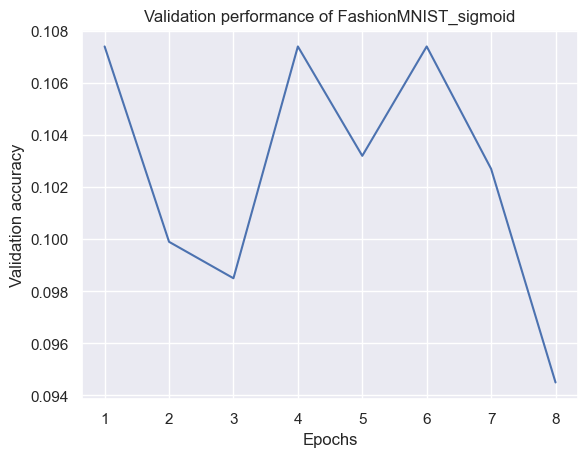

============= Test accuracy: 10.00% ==============

Training BaseNetwork with tanh activation...
Model file exists, but will be overwritten...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 66.47%, Validation accuracy: 77.99%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 81.39%, Validation accuracy: 82.04%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 84.07%, Validation accuracy: 84.40%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 85.21%, Validation accuracy: 84.46%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 85.77%, Validation accuracy: 84.34%


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 86.37%, Validation accuracy: 86.53%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 86.80%, Validation accuracy: 86.52%


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 87.32%, Validation accuracy: 86.19%


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 87.34%, Validation accuracy: 85.36%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 87.87%, Validation accuracy: 86.72%
	   (New best performance, saving model...)


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 88.45%, Validation accuracy: 86.89%
	   (New best performance, saving model...)


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 88.41%, Validation accuracy: 87.48%
	   (New best performance, saving model...)


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 88.75%, Validation accuracy: 87.52%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 88.93%, Validation accuracy: 87.35%


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 89.28%, Validation accuracy: 87.18%


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 89.53%, Validation accuracy: 88.12%
	   (New best performance, saving model...)


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 89.85%, Validation accuracy: 87.74%


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 89.82%, Validation accuracy: 88.19%
	   (New best performance, saving model...)


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 90.28%, Validation accuracy: 87.53%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 90.25%, Validation accuracy: 88.48%
	   (New best performance, saving model...)


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 90.51%, Validation accuracy: 88.46%


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 90.77%, Validation accuracy: 88.24%


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 91.10%, Validation accuracy: 88.08%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 90.91%, Validation accuracy: 88.36%


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 91.09%, Validation accuracy: 88.67%
	   (New best performance, saving model...)


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 91.42%, Validation accuracy: 88.22%


Epoch 27:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 91.58%, Validation accuracy: 89.14%
	   (New best performance, saving model...)


Epoch 28:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 91.86%, Validation accuracy: 89.12%


Epoch 29:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 91.96%, Validation accuracy: 88.31%


Epoch 30:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 92.02%, Validation accuracy: 88.45%


Epoch 31:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 92.04%, Validation accuracy: 88.28%


Epoch 32:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 92.44%, Validation accuracy: 89.13%


Epoch 33:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 92.20%, Validation accuracy: 88.43%


Epoch 34:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 92.42%, Validation accuracy: 89.30%
	   (New best performance, saving model...)


Epoch 35:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 92.59%, Validation accuracy: 89.34%
	   (New best performance, saving model...)


Epoch 36:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 93.05%, Validation accuracy: 88.91%


Epoch 37:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 37] Training accuracy: 92.90%, Validation accuracy: 89.28%


Epoch 38:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 38] Training accuracy: 93.19%, Validation accuracy: 89.19%


Epoch 39:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 39] Training accuracy: 93.45%, Validation accuracy: 88.36%


Epoch 40:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 40] Training accuracy: 93.52%, Validation accuracy: 89.18%


Epoch 41:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 41] Training accuracy: 93.53%, Validation accuracy: 89.03%


Epoch 42:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 42] Training accuracy: 93.79%, Validation accuracy: 89.22%
Early stopping due to no improvement over the last 7 epochs


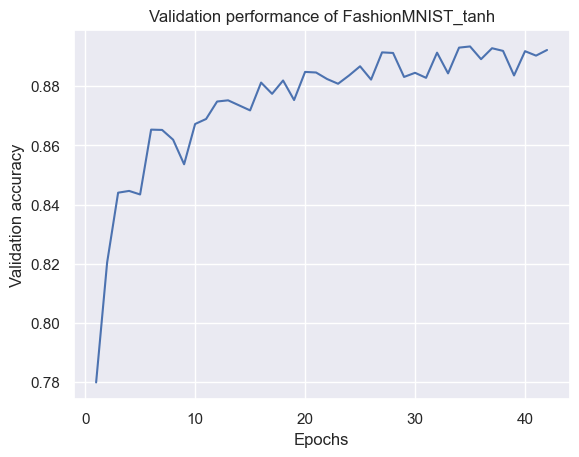

============= Test accuracy: 88.09% ==============

Training BaseNetwork with relu activation...
Model file exists, but will be overwritten...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 50.06%, Validation accuracy: 73.25%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 78.88%, Validation accuracy: 80.95%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 83.12%, Validation accuracy: 84.19%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 84.90%, Validation accuracy: 84.88%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 85.71%, Validation accuracy: 85.02%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 86.79%, Validation accuracy: 86.64%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 87.50%, Validation accuracy: 87.31%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 88.28%, Validation accuracy: 87.40%
	   (New best performance, saving model...)


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 88.56%, Validation accuracy: 85.95%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 89.00%, Validation accuracy: 87.23%


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 89.53%, Validation accuracy: 87.90%
	   (New best performance, saving model...)


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 89.74%, Validation accuracy: 87.44%


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 90.20%, Validation accuracy: 88.93%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 90.61%, Validation accuracy: 87.62%


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 90.90%, Validation accuracy: 87.71%


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 91.34%, Validation accuracy: 87.80%


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 91.32%, Validation accuracy: 89.49%
	   (New best performance, saving model...)


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 91.57%, Validation accuracy: 88.55%


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 92.09%, Validation accuracy: 88.62%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 92.18%, Validation accuracy: 88.89%


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 92.68%, Validation accuracy: 88.80%


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 92.87%, Validation accuracy: 89.45%


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 93.19%, Validation accuracy: 89.12%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 93.24%, Validation accuracy: 88.99%
Early stopping due to no improvement over the last 7 epochs


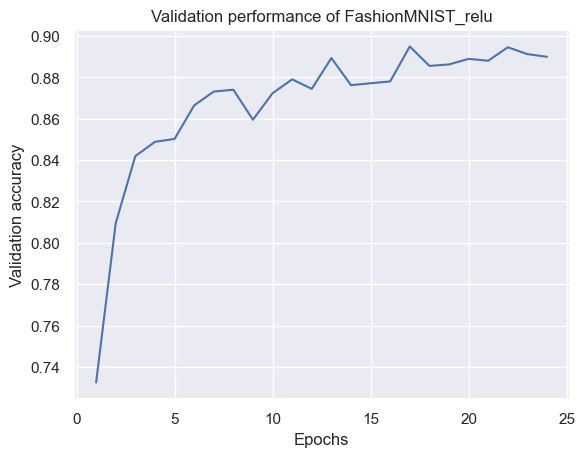

============= Test accuracy: 88.58% ==============

Training BaseNetwork with leakyrelu activation...
Model file exists, but will be overwritten...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 51.01%, Validation accuracy: 74.58%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 79.20%, Validation accuracy: 80.53%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 83.03%, Validation accuracy: 83.89%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 84.80%, Validation accuracy: 84.66%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 85.54%, Validation accuracy: 85.25%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 86.56%, Validation accuracy: 86.55%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 87.25%, Validation accuracy: 87.10%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 87.92%, Validation accuracy: 86.94%


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 88.27%, Validation accuracy: 86.43%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 88.65%, Validation accuracy: 87.38%
	   (New best performance, saving model...)


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 89.10%, Validation accuracy: 87.64%
	   (New best performance, saving model...)


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 89.35%, Validation accuracy: 87.01%


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 89.65%, Validation accuracy: 88.58%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 90.03%, Validation accuracy: 87.38%


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 90.37%, Validation accuracy: 87.24%


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 90.74%, Validation accuracy: 87.99%


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 90.80%, Validation accuracy: 89.08%
	   (New best performance, saving model...)


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 91.01%, Validation accuracy: 88.79%


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 91.58%, Validation accuracy: 88.37%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 91.56%, Validation accuracy: 89.03%


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 92.05%, Validation accuracy: 88.80%


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 92.10%, Validation accuracy: 89.33%
	   (New best performance, saving model...)


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 92.47%, Validation accuracy: 89.05%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 92.65%, Validation accuracy: 89.00%


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 92.83%, Validation accuracy: 88.75%


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 93.13%, Validation accuracy: 89.40%
	   (New best performance, saving model...)


Epoch 27:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 93.14%, Validation accuracy: 89.24%


Epoch 28:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 93.34%, Validation accuracy: 88.56%


Epoch 29:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 93.73%, Validation accuracy: 89.09%


Epoch 30:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 93.48%, Validation accuracy: 88.62%


Epoch 31:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 93.85%, Validation accuracy: 89.62%
	   (New best performance, saving model...)


Epoch 32:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 94.27%, Validation accuracy: 89.07%


Epoch 33:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 94.08%, Validation accuracy: 88.78%


Epoch 34:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 94.36%, Validation accuracy: 89.02%


Epoch 35:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 94.74%, Validation accuracy: 89.59%


Epoch 36:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 95.00%, Validation accuracy: 89.30%


Epoch 37:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 37] Training accuracy: 94.90%, Validation accuracy: 89.30%


Epoch 38:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 38] Training accuracy: 94.94%, Validation accuracy: 88.85%
Early stopping due to no improvement over the last 7 epochs


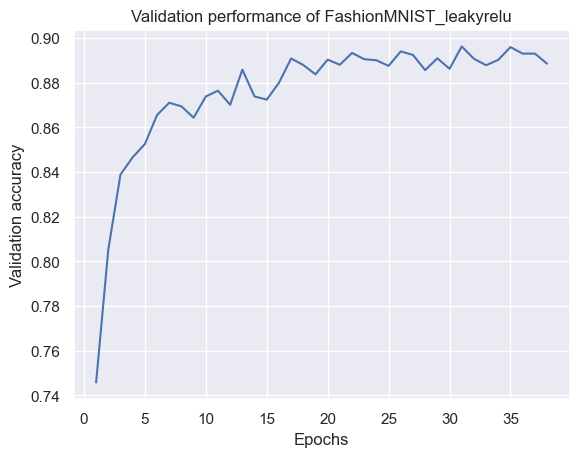

============= Test accuracy: 88.69% ==============

Training BaseNetwork with elu activation...
Model file exists, but will be overwritten...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 66.24%, Validation accuracy: 78.28%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 81.45%, Validation accuracy: 82.09%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 83.84%, Validation accuracy: 84.07%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 84.99%, Validation accuracy: 84.69%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 85.50%, Validation accuracy: 85.15%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 86.06%, Validation accuracy: 86.09%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 86.57%, Validation accuracy: 86.21%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 86.92%, Validation accuracy: 85.84%


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 87.06%, Validation accuracy: 84.44%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 87.45%, Validation accuracy: 87.27%
	   (New best performance, saving model...)


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 87.91%, Validation accuracy: 86.08%


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 88.14%, Validation accuracy: 87.03%


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 88.36%, Validation accuracy: 87.16%


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 88.58%, Validation accuracy: 87.36%
	   (New best performance, saving model...)


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 88.76%, Validation accuracy: 86.78%


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 88.98%, Validation accuracy: 87.89%
	   (New best performance, saving model...)


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 89.26%, Validation accuracy: 87.67%


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 89.40%, Validation accuracy: 88.04%
	   (New best performance, saving model...)


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 89.58%, Validation accuracy: 87.49%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 89.76%, Validation accuracy: 87.94%


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 90.03%, Validation accuracy: 88.06%
	   (New best performance, saving model...)


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 90.22%, Validation accuracy: 88.22%
	   (New best performance, saving model...)


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 90.47%, Validation accuracy: 87.89%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 90.40%, Validation accuracy: 88.58%
	   (New best performance, saving model...)


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 90.61%, Validation accuracy: 88.13%


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 90.79%, Validation accuracy: 87.99%


Epoch 27:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 90.75%, Validation accuracy: 88.35%


Epoch 28:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 91.09%, Validation accuracy: 88.64%
	   (New best performance, saving model...)


Epoch 29:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 91.05%, Validation accuracy: 88.60%


Epoch 30:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 91.34%, Validation accuracy: 88.84%
	   (New best performance, saving model...)


Epoch 31:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 91.42%, Validation accuracy: 88.75%


Epoch 32:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 91.57%, Validation accuracy: 88.81%


Epoch 33:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 91.55%, Validation accuracy: 88.70%


Epoch 34:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 91.63%, Validation accuracy: 89.01%
	   (New best performance, saving model...)


Epoch 35:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 91.85%, Validation accuracy: 88.77%


Epoch 36:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 92.03%, Validation accuracy: 88.87%


Epoch 37:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 37] Training accuracy: 92.07%, Validation accuracy: 88.56%


Epoch 38:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 38] Training accuracy: 92.24%, Validation accuracy: 88.85%


Epoch 39:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 39] Training accuracy: 92.30%, Validation accuracy: 88.16%


Epoch 40:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 40] Training accuracy: 92.38%, Validation accuracy: 88.58%


Epoch 41:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 41] Training accuracy: 92.54%, Validation accuracy: 88.55%
Early stopping due to no improvement over the last 7 epochs


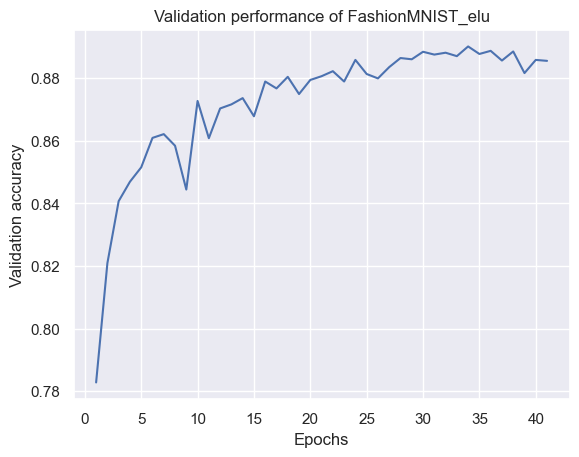

============= Test accuracy: 87.77% ==============

Training BaseNetwork with swish activation...
Model file exists, but will be overwritten...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 28.05%, Validation accuracy: 30.44%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 65.12%, Validation accuracy: 74.24%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 79.37%, Validation accuracy: 81.53%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 82.46%, Validation accuracy: 83.27%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 83.86%, Validation accuracy: 81.90%


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 84.84%, Validation accuracy: 84.82%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 85.55%, Validation accuracy: 85.16%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 86.06%, Validation accuracy: 85.03%


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 86.22%, Validation accuracy: 84.25%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 86.66%, Validation accuracy: 86.16%
	   (New best performance, saving model...)


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 87.08%, Validation accuracy: 85.88%


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 87.37%, Validation accuracy: 86.85%
	   (New best performance, saving model...)


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 87.60%, Validation accuracy: 86.74%


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 87.73%, Validation accuracy: 87.41%
	   (New best performance, saving model...)


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 88.17%, Validation accuracy: 85.57%


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 88.37%, Validation accuracy: 87.51%
	   (New best performance, saving model...)


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 88.76%, Validation accuracy: 87.13%


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 88.91%, Validation accuracy: 87.75%
	   (New best performance, saving model...)


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 89.07%, Validation accuracy: 87.57%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 89.24%, Validation accuracy: 87.97%
	   (New best performance, saving model...)


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 89.48%, Validation accuracy: 87.57%


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 89.56%, Validation accuracy: 87.66%


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 90.01%, Validation accuracy: 87.52%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 89.87%, Validation accuracy: 88.26%
	   (New best performance, saving model...)


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 90.17%, Validation accuracy: 88.32%
	   (New best performance, saving model...)


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 90.28%, Validation accuracy: 87.80%


Epoch 27:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 90.39%, Validation accuracy: 88.55%
	   (New best performance, saving model...)


Epoch 28:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 90.64%, Validation accuracy: 88.65%
	   (New best performance, saving model...)


Epoch 29:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 90.75%, Validation accuracy: 88.38%


Epoch 30:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 91.06%, Validation accuracy: 88.93%
	   (New best performance, saving model...)


Epoch 31:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 91.13%, Validation accuracy: 88.32%


Epoch 32:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 91.23%, Validation accuracy: 89.03%
	   (New best performance, saving model...)


Epoch 33:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 91.31%, Validation accuracy: 88.58%


Epoch 34:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 91.43%, Validation accuracy: 88.60%


Epoch 35:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 91.62%, Validation accuracy: 89.16%
	   (New best performance, saving model...)


Epoch 36:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 91.81%, Validation accuracy: 88.56%


Epoch 37:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 37] Training accuracy: 91.90%, Validation accuracy: 88.66%


Epoch 38:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 38] Training accuracy: 92.01%, Validation accuracy: 88.36%


Epoch 39:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 39] Training accuracy: 92.08%, Validation accuracy: 88.71%


Epoch 40:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 40] Training accuracy: 92.24%, Validation accuracy: 88.82%


Epoch 41:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 41] Training accuracy: 92.31%, Validation accuracy: 88.45%


Epoch 42:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 42] Training accuracy: 92.83%, Validation accuracy: 88.52%
Early stopping due to no improvement over the last 7 epochs


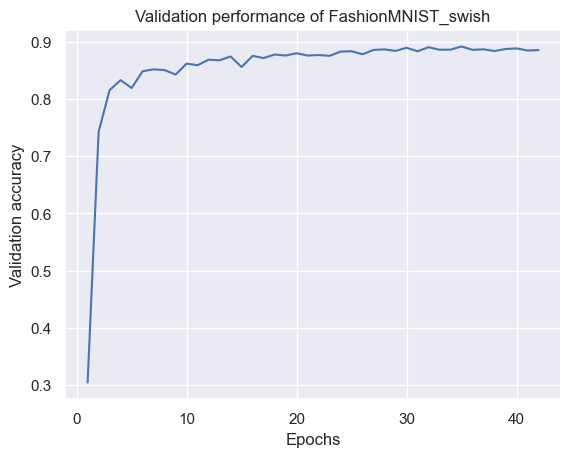

============= Test accuracy: 88.08% ==============



In [18]:
for act_fn_name in act_fn_by_name:
    print(f"Training BaseNetwork with {act_fn_name} activation...")
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = BaseNetwork(act_fn=act_fn).to(device)
    train_model(net_actfn, f"FashionMNIST_{act_fn_name}", overwrite=True)

Unsurprisingly, the model using the sigmoid activation function fails and does not improve upon random performance (10 classes => 1/10 for random chance). This is because the gradient of the input layer parameters on the loss function is negligible compared to the other layers.
All the other activation functions gain similar performance. To have a more accurate conclusion, we would have to train the models for multiple seeds and look at the averages. However, the "optimal" activation function also depends on many other factors (hidden sizes, number of layers, type of layers, task, dataset, optimizer, learning rate, etc.), meaning a thorough grid search would not be useful in our case.
In the literature, activation functions that have shown to work well with deep networks are all types of ReLU functions that we experimented with here, with small gains for specific activation functions in specific networks.

### Visualising the activation distribution 

After we have trained the models, we can look at the actual activation values that are found inside the model. This may provide further insight into the model's performance.

<div style="background-color:#C2F5DD">
    
### Exercise
    
Write a simple function which takes a trained model, applies it to a batch of images, and plots the histogram of the activation function outputs inside the network. Use the histograms to answer the following questions:
    
- How many neurons are set to zero in ReLU? 
- Where do we find most values in Tanh?



In [19]:
def visualize_activations(net, color="C0"):
    activations = {}
    
    net.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024)
    imgs, labels = next(iter(small_loader))
    with torch.no_grad():
        layer_index = 0
        imgs = imgs.to(device)
        imgs = imgs.view(imgs.size(0), -1)
        # We need to manually loop through the layers to save all activations
        for layer_index, layer in enumerate(net.layers[:-1]):
            imgs = layer(imgs)
            activations[layer_index] = imgs.view(-1).cpu().numpy() #reshapes tensor
    
    ## Plotting
    columns = 4
    rows = math.ceil(len(activations)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(columns*2.7, rows*2.5))
    fig_index = 0
    for key in activations:
        key_ax = ax[fig_index//columns][fig_index%columns]
        sns.histplot(data=activations[key], bins=50, ax=key_ax, color=color, kde=True, stat="density")
        key_ax.set_title(f"Layer {key} - {net.layers[key].__class__.__name__}")
        fig_index += 1
    fig.suptitle(f"Activation distribution for activation function {net.config['act_fn']['name']}", fontsize=14)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()
    plt.close() 

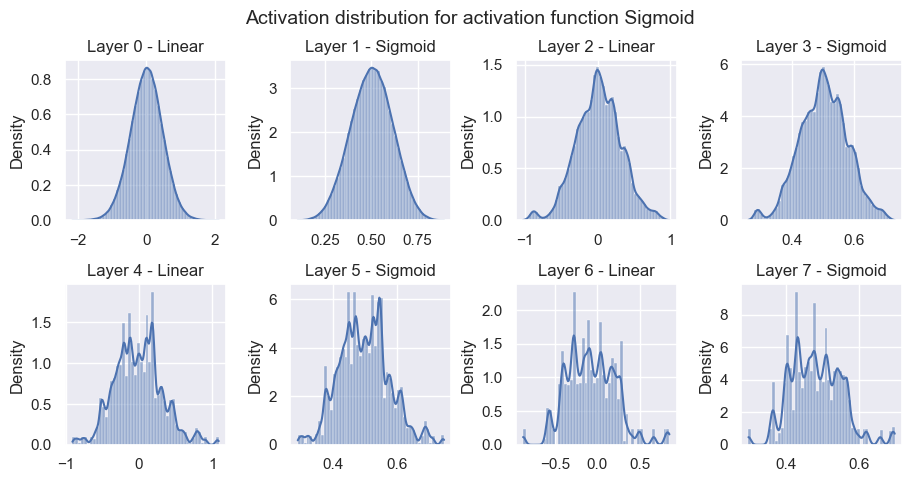

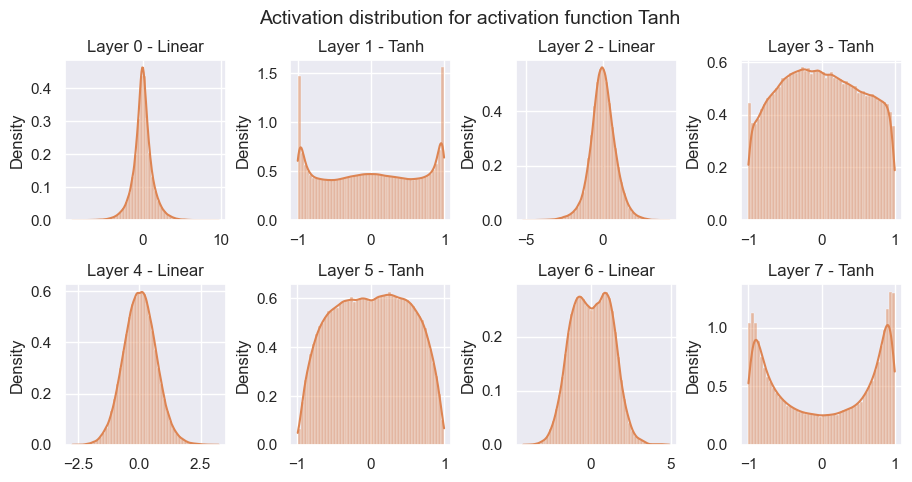

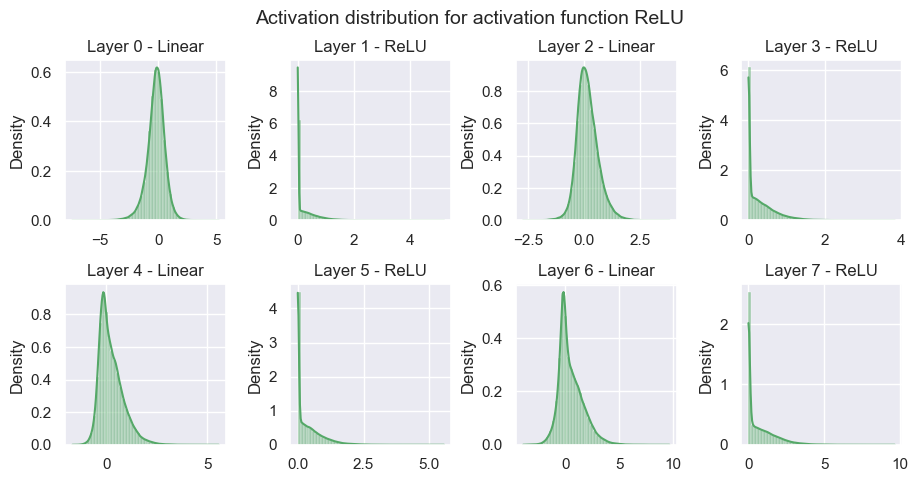

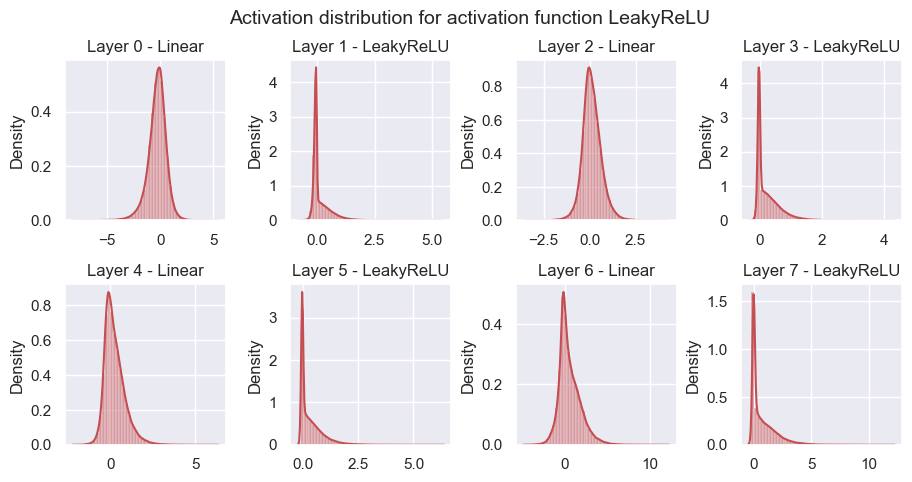

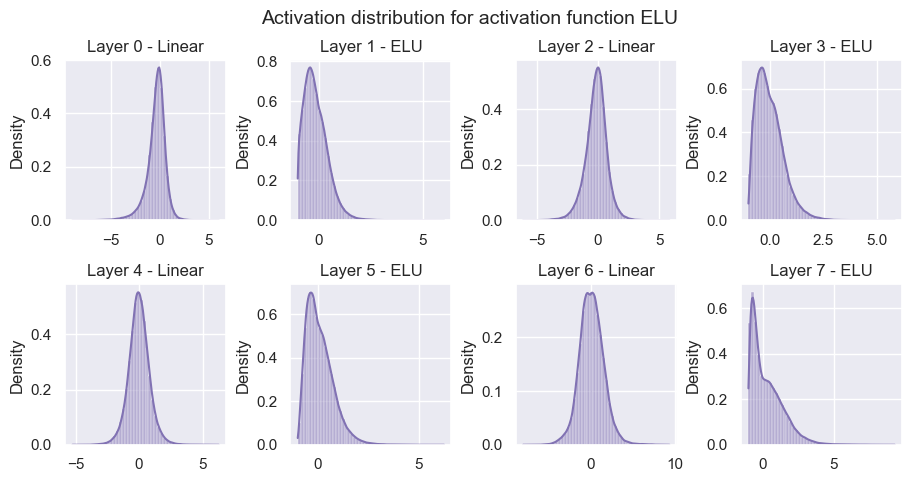

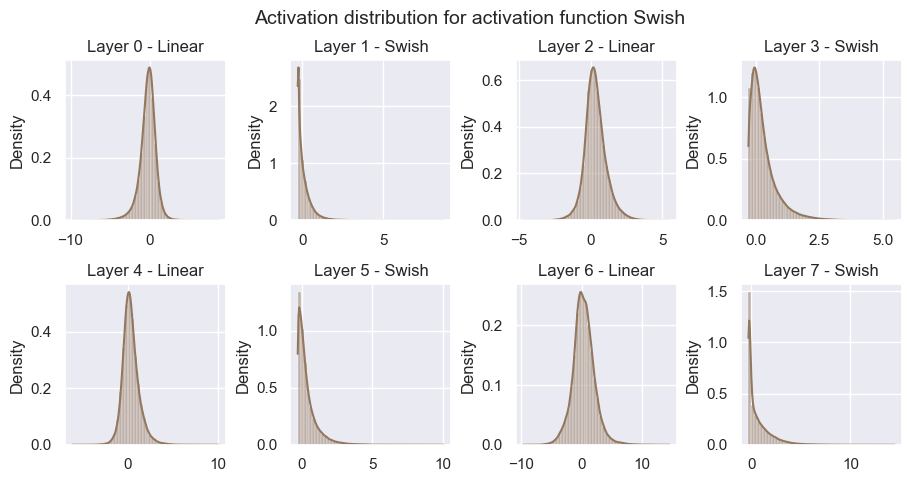

In [20]:
for i, act_fn_name in enumerate(act_fn_by_name):
    net_actfn = load_model(model_path=CHECKPOINT_PATH, model_name=f"FashionMNIST_{act_fn_name}").to(device)
    visualize_activations(net_actfn, color=f"C{i}")

As the model with **sigmoid** activation was not able to train properly, the activation outputs (or 'activations') are also less informative and are all gathered around 0.5 (this is what the activation function returns for an input of 0).

**Tanh** shows more diverse behavior. 
- In the input layer, we see a larger number of neuron outputs close to -1 and 1 (the expected outputs when the gradients are close to 0), whereas the values in the two consecutive layers are closer to zero. This is probably because the input layers look for specific features in the input image, and the consecutive layers combine those together. 
- The activations for the last layer are again more biased to the extreme values. This is because neurons in the middle layers are simply identifying features and weighting their importance, and there can be many such features. However, the last layer is the true classifier layer. Each neuron must produce the probability that a data instance belongs to a particular set on not, and thus returning extreme values is more instructive.

**ReLU** has a strong peak at 0, as we initially expected. The effect of having no gradients for negative values is that the network does not have a Gaussian-like distribution after the linear layers, but instead has a longer tail towards the positive values. 

**LeakyReLU** shows very similar behaviour, whereas **ELU** follows a more Gaussian-like distribution. The **Swish activation** seems to lie in between, although it is worth noting that Swish uses significantly higher activations than other activation functions (up to a value of 20).

We see that all activation functions show slightly different behaviuor, although obtaining similar performances for our simple network. Thus it is apparent that the selection of the "optimal" activation function really depends on many factors, and is not the same for all possible networks.


The tanh shows a more diverse behaviour. While for the input layer we see a larger amount of neurons (neuron outputs?) to be close to -1 and 1 (where the gradients are close to zero), the values in the two consecutive layers are closer to zero. This is probably because the input layers look for specific features in the input image, and the consecutive layers combine those together. The activations for the last layer are again more biased to the extreme points. 


because the classification layer can be seen as a weighted average of those values (the gradients push the activations to those extremes).



<hr style="border:2px solid gray">

# Dead Neurons [^](#index) <a id='dead-neurons'></a>

One known drawback of the ReLU activation is the occurrence of "dead neurons". These are neurons with **no gradient** (or only a small gradient) for any training input. For ReLU, this is true if the neuron returns 0 for all the given input data.

A neural network trains by calculating the gradient of the loss function wrt each layer's parameters. If the gradient calculated when backpropogating is close to 0, the associated parameters will update very slowly (or not at all). This an cause the training to slow or to stall.

A neuron first calculates `'z'`, the output of the linear function, before passing this value to the activation function. If this `'z'` is negative, the ReLU function will then always return 0, resulting in a dead neuron.

Considering the large number of neurons we have in a neural network, it is not unlikely for this to occur. 

To get a better understanding of how much of a problem this is, and when we need to be careful, we will measure how many dead neurons different networks have. 
    

<div style="background-color:#C2F5DD">

### Exercise
    
Implement a function which runs the network on the whole training set and records whether a neuron is exactly 0 for all data points or not.

We will then use this function to measure the number of dead neurons in an untrained ReLU activation function network:   

In [21]:
def measure_number_dead_neurons(net):

    # For each neuron, we create a boolean variable initially set to 1. If it has an activation unequals 0 at any time,
    # we set this variable to 0. After running through the whole training set, only dead neurons will have a 1.
    neurons_dead = [
        torch.ones(layer.weight.shape[0], device=device, dtype=torch.bool) for layer in net.layers[:-1] if isinstance(layer, nn.Linear)
    ] # Same shapes as hidden size in BaseNetwork

    net.eval()
    with torch.no_grad():
        for imgs, labels in tqdm(train_loader, leave=False): # Run through whole training set
            layer_index = 0
            imgs = imgs.to(device)
            imgs = imgs.view(imgs.size(0), -1)
            for layer in net.layers[:-1]:
                imgs = layer(imgs)
                if isinstance(layer, ActivationFunction):
                    
                    # Are all activations == 0 in the batch, and we did not record the opposite in the last batches?
                    neurons_dead[layer_index] = torch.logical_and(neurons_dead[layer_index], (imgs == 0).all(dim=0))
                    layer_index += 1
    number_neurons_dead = [t.sum().item() for t in neurons_dead]
    print("Number of dead neurons:", number_neurons_dead)
    print("In percentage:", ", ".join([f"{(100.0 * num_dead / tens.shape[0]):4.2f}%" for tens, num_dead in zip(neurons_dead, number_neurons_dead)]))

In [22]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU()).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 3, 10]
In percentage: 0.00%, 0.00%, 1.17%, 7.81%


We see that only a minor amount of neurons are dead, but that the number of dead neurons increases with the depth of the layer.

This is not too great of an issue if we only have a small number of dead neurons, such as in this case. As weights are updated in the training process, the inputs to these later layers will change too. These new inputs could allow the dead neuron to become "alive"/active again. 

<div style="background-color:#C2F5DD">
    
### Exercise

Measure the number of dead neurons for different activation functions. Are the results what you expect?

In [23]:
set_seed(42)
net_elu = BaseNetwork(act_fn=ELU()).to(device)
measure_number_dead_neurons(net_elu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 0, 0]
In percentage: 0.00%, 0.00%, 0.00%, 0.00%


Now let us look at this for a **trained** ReLU network (with the same initialisation):

In [24]:
net_relu = load_model(model_path=CHECKPOINT_PATH, model_name="FashionMNIST_relu").to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 2, 5]
In percentage: 0.00%, 0.00%, 0.78%, 3.91%


The number of dead neurons has indeed decreased in the later layers. However, dead neurons are especially problematic in the input layer. The training data is fixed and thus the inputs to the input layer will not change over epochs. Training the network **cannot** make these neurons become active.

Usually, the input data has a sufficiently high standard deviation to reduce the risk of dead neurons (the range of inputs is quite varied).

<div style="background-color:#C2F5DD">

### Exercise
    
Investigate how the number of dead neurons changes with increasing layer depth. For instance, try building a 10-layer neural network with 256 nodes in the first 5 layers and 128 nodes in the last 5:

In [25]:
set_seed(42)
net_relu = BaseNetwork(act_fn=ReLU(), hidden_sizes=[256, 256, 256, 256, 256, 128, 128, 128, 128, 128]).to(device)
measure_number_dead_neurons(net_relu)

  0%|          | 0/49 [00:00<?, ?it/s]

Number of dead neurons: [0, 0, 7, 27, 89, 60, 58, 61, 72, 56]
In percentage: 0.00%, 0.00%, 2.73%, 10.55%, 34.77%, 46.88%, 45.31%, 47.66%, 56.25%, 43.75%


The number of dead neurons is significantly higher than before which harms the gradient flow, especially in the first iterations. For instance, more than 56% of the neurons in the pre-last layer are dead which creates a considerable bottleneck.
It is therefore advisible to use other nonlinear activation functions like Swish for very deep networks.

<hr style="border:2px solid gray">

# Improving neural network performance [^](#index) <a id='nn-toolbox'></a>

We have briefly talked about regularisation in the ML algorithms we have seen so far, including hyperparameters we can tune or additional methods we can apply to make sure our models can generalise successfully. We will now see how we can do this in neural networks, as well as some other methods to improve training and performance.

## Dropout

One way we can try to stop our model from overfitting is to include **dropout** layers: 

* When we pass a vector into a dropout layer, we randomly set each element to 0 with some specified probability $p$ 

* At each epoch of our neural network training, different elements can be zeroed

* The network therefore has to learn from **all** parts of the input, rather than just learning correlations involving specific features

* We can also imagine this as training something adjacent to an ensemble model, as it effectively changes the network architecture slightly each epoch

* At prediction time, this is ignored i.e. no entries are zeroed when we make predictions

In fact, dropout is one of the most common other types of layer to include in neural networks, because of the success they provide in regularisation. It isn't a perfect solution, as it adds an additional hyperparameter that needs optimising (the dropout probability $p$), and can slow training down, but it generally is a good idea to include dropout layers in neural networks.

These are easily included in PyTorch models as `nn.Dropout`. Here is an example of a simple two layer neural network for classification with a dropout layer, with $p = 0.2$:



In [ ]:
in_channels = 10
hidden_channels = 5
out_channels = 1

model = nn.Sequential(nn.Linear(in_channels, hidden_channels),
                      nn.ReLU(),
                      nn.Dropout(p = 0.2),
                      nn.Linear(hidden_channels, out_channels),
                      nn.Sigmoid())

This is all there is to it when adding a dropout layer. We can verify a dropout layer works as we expect:

In [ ]:
torch.manual_seed(0) # set random seed for reproducibility here

input = torch.randn(20)
print(input)
drop = nn.Dropout(p = 0.2)
output = drop(input)
print(output)

tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.5988, -1.5551, -0.3414,  1.8530,
         0.4681, -0.1577,  1.4437,  0.2660,  1.3894,  1.5863,  0.9463, -0.8437,
         0.9318,  1.2590,  2.0050,  0.0537])
tensor([-1.4073, -1.4405, -0.3132, -0.5423,  0.7485, -1.9439, -0.4267,  2.3163,
         0.5851, -0.1971,  1.8046,  0.3326,  0.0000,  1.9829,  1.1829, -1.0546,
         1.1648,  0.0000,  2.5062,  0.0672])


We can clearly see a number of our entries have been set to 0. One other thing to note is that you can see the non-zero values in our output are not the same as in our input. This is because the dropout layer also re-scales the remaining entries by a factor of $\frac{1}{1 - p}$, for stability. 

We can also verify that it does not do anything if we put the layer in `eval` mode:

In [ ]:
drop.eval()
output_eval = drop(input)
print(output_eval)
print(f"Eval output same as input: {(input==output_eval).all()}")

tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.5988, -1.5551, -0.3414,  1.8530,
         0.4681, -0.1577,  1.4437,  0.2660,  1.3894,  1.5863,  0.9463, -0.8437,
         0.9318,  1.2590,  2.0050,  0.0537])
Eval output same as input: True


We can clearly see that our output in `eval` mode is the same as our input. This means our dropout layers won't cause any issues at prediction time and only operate during training.

Generally speaking, it is good to include dropout layers after each hidden activation function, but not at the end of the model. The best value of $p$ is something you need to determine, but often good a good place to start is somewhere between 0.1 and 0.5. You can read more about the performance improvements seen when dropout was first proposed in the [initial paper](https://arxiv.org/abs/1207.0580).

## Batch normalisation

To ensure good performance of neural networks, we need to make sure the training process goes smoothly, and ideally quickly. 

Because each layer output depends on the input, the weights of earlier layers affect the training of later layers; this is referred to as **internal covariate shift**. This can cause problems in our training, as later layers may need to make more dramatic or regular weight changes as the earlier layer weights change. 

In fact, we've seen a similar idea in preprocessing ideas we have seen before:

* Our ML methods can be sensitive to the scale of features, so it is often good to scale our data before training

* Because each layer of a neural network multiplies each input by a set of arbitrary weights, the scale of each output vector entry can be very different

* As a result, subsequent layers can have inputs with wildly different scales for each input neuron

In fact, method known as **batch normalisation** was first proposed to tackle this problem. The basic idea is that we can normalise the distribution of each output neutron from a layer according to the mean and variance of those outputs, across the entire dataset. This was first proposed in [this paper](https://arxiv.org/abs/1502.03167).

Of course, when training we cannot just compute this normalisation over the whole dataset in general, as we train using batches; instead, we estimate the mean and variance of the values from each batch and normalise based on those. This is why this method is called batch normalisation, as we are normalising over the batch.

<div style="background-color:#FFCCCB">

First, we define the following:

* $N$: the number of data points in our batch

* $d$: the number of dimensions of a single data point

* $x^{(i)}_j$ denotes the $i$-th vector entry in the $j$-th data point in the batch

Then, we want to normalise each feature separately across the batch. To do this, we first define the mean and variance:

\begin{align*}
\mu_\mathcal{B}^{(i)} &= \frac{1}{N}\sum_{j = 1}^N x^{(i)}_j \\
\left(\sigma_\mathcal{B}^{(i)}\right)^2 &= \frac{1}{N}\sum_{j = 1}^N \left(x^{(i)}_i - \mu_\mathcal{B}^{(i)}\right)^2,
\end{align*}
where $\mu_\mathcal{B}^{(i)}$ and $\left(\sigma_\mathcal{B}^{(i)}\right)^2$ denote the mean and variance for dimension $i$ across the batch $\mathcal{B}$ respectively.

Finally, we can define the normalised values as

\begin{equation*}
\hat{x}^{(i)}_j = \frac{x^{(i)}_j - \mu_\mathcal{B}^{(i)}}{\sigma_\mathcal{B}^{(i)}},
\end{equation*}
where $\hat{x}^{(i)}_j$ denotes the rescaled value for element $i$ of the $j$-th data point.

</div>

However, just normalising in this way will reduce the set of functions our layer can represent; it might constrain the output to specific regions of the activation function, e.g. we could only have outputs in the linear region of a sigmoid. 

To overcome this, we include a pair of learnable parameters for each dimension to shift and scale the value. This ensures the model can still recover the initial distribution of each dimension, if that is the best for performance.

<div style="background-color:#FFCCCB">

We can denote this final rescaling according to

\begin{equation*}
y^{(i)}_j = \gamma^{(i)} \hat{x}^{(i)}_j + \Beta^{(i)},
\end{equation*}
where $y^{(i)}_j$ is the $i$-th dimension of the $j$-th data point after batch normalisation, and $\gamma^{(i)}$ and $\Beta^{(i)}$ are two learnable parameters for dimension $i$. 







This is helpfully implemented in PyTorch for different dimensions of input. For now, we will just look at `nn.BatchNorm1d`, which you can read about in detail in the [documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d). 

In [ ]:
num_features = 10

batch_norm = nn.BatchNorm1d(num_features = 10)

This will create a batch norm layer that expects 10 features, so any input passed to it is expected to have shape ($N_\text{batch}$, $10$). You can then just put this in a standard neural network architecture.

During training, a batch norm layer keeps a running mean and variance as well as computing the mean and variance for each batch. This means that when it comes to prediction, the normalisation is done based the mean and variance estimated across all of the data seen during training. 

There is some debate as to whether we should use batch normalisation before or after the activation function, i.e. which of the following three layer arrangements we should use:

In [ ]:
in_channels = 10
hidden_channels = 10

arrangement_1 = nn.Sequential([nn.Linear(in_channels, hidden_channels), 
                               nn.BatchNorm1d(hidden_channels),
                               nn.ReLU()])

arrangement_2 = nn.Sequential([nn.Linear([in_channels, hidden_channels]),
                               nn.ReLU(),
                               nn.BatchNorm1d(hidden_channels)])

In fact, while the original paper suggests using batch normalisation before activation functions (i.e. `arrangement_1`), some prominent ML scientists have suggested that using batch normalisation after activation functions is more appropriate (i.e. `arrangement_2`). In general, you can experiment to see which performs better.

In practise, using batch normalisation in our network stabilises training, meaning we generally converge faster and we can often use higher learning rates than training without batch normalisation. If training is taking a long time or you are seeing small gradients later in the network, it often is a good sign to try using batch normalisation.

<div style="background-color:#C2F5DD">

### Exercise

In the next code cell, complete the `BaseNetworkNorm` class definition to include batch normalisation after each linear layer, either before or after the activation function (your choice). 

Then, use the existing training code to train a `BaseNetworkNorm` on FashionMNIST with a ReLU activation function, and compare with your results from earlier. How does the test performance compare? Visualise the test performance as a function of epoch.

You should see that with batch normalisation we reach equivalent test performance at earlier epochs than without.

In [31]:
class BaseNetworkNorm(nn.Module):
    
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()
        
        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn,
                       nn.BatchNorm1d(layer_sizes[layer_index])]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.Sequential(*layers) # nn.Sequential summarizes a list of modules into a single module, applying them in sequence
        
        # We store all hyperparameters in a dictionary for saving and loading of the model
        self.config = {"act_fn": act_fn.config, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes} 
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # Reshape images to a flat vector
        out = self.layers(x)
        return out    

Model file exists, but will be overwritten...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 48.18%, Validation accuracy: 74.69%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 79.00%, Validation accuracy: 81.73%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 83.34%, Validation accuracy: 83.57%
	   (New best performance, saving model...)


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 85.02%, Validation accuracy: 84.82%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 86.08%, Validation accuracy: 85.75%
	   (New best performance, saving model...)


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 86.80%, Validation accuracy: 85.98%
	   (New best performance, saving model...)


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 87.64%, Validation accuracy: 87.10%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 88.18%, Validation accuracy: 87.39%
	   (New best performance, saving model...)


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 88.92%, Validation accuracy: 88.06%
	   (New best performance, saving model...)


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 88.95%, Validation accuracy: 84.70%


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 89.46%, Validation accuracy: 87.75%


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 90.09%, Validation accuracy: 88.25%
	   (New best performance, saving model...)


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 90.38%, Validation accuracy: 88.64%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 90.56%, Validation accuracy: 88.40%


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 90.81%, Validation accuracy: 88.03%


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 91.17%, Validation accuracy: 88.57%


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 91.43%, Validation accuracy: 89.08%
	   (New best performance, saving model...)


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 91.65%, Validation accuracy: 88.68%


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 92.12%, Validation accuracy: 88.77%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 91.96%, Validation accuracy: 88.75%


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 92.51%, Validation accuracy: 89.32%
	   (New best performance, saving model...)


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 92.78%, Validation accuracy: 88.79%


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 93.09%, Validation accuracy: 88.38%


Epoch 24:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 24] Training accuracy: 93.12%, Validation accuracy: 88.60%


Epoch 25:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 25] Training accuracy: 93.55%, Validation accuracy: 89.43%
	   (New best performance, saving model...)


Epoch 26:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 26] Training accuracy: 93.64%, Validation accuracy: 89.18%


Epoch 27:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 27] Training accuracy: 93.81%, Validation accuracy: 89.31%


Epoch 28:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 28] Training accuracy: 94.39%, Validation accuracy: 89.00%


Epoch 29:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 29] Training accuracy: 94.50%, Validation accuracy: 88.87%


Epoch 30:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 30] Training accuracy: 94.50%, Validation accuracy: 88.13%


Epoch 31:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 31] Training accuracy: 94.78%, Validation accuracy: 89.06%


Epoch 32:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 32] Training accuracy: 94.48%, Validation accuracy: 89.68%
	   (New best performance, saving model...)


Epoch 33:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 33] Training accuracy: 94.95%, Validation accuracy: 89.22%


Epoch 34:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 34] Training accuracy: 95.50%, Validation accuracy: 89.33%


Epoch 35:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 35] Training accuracy: 95.24%, Validation accuracy: 89.26%


Epoch 36:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 36] Training accuracy: 95.27%, Validation accuracy: 88.67%


Epoch 37:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 37] Training accuracy: 95.52%, Validation accuracy: 89.11%


Epoch 38:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 38] Training accuracy: 96.05%, Validation accuracy: 88.91%


Epoch 39:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 39] Training accuracy: 96.38%, Validation accuracy: 88.49%
Early stopping due to no improvement over the last 7 epochs


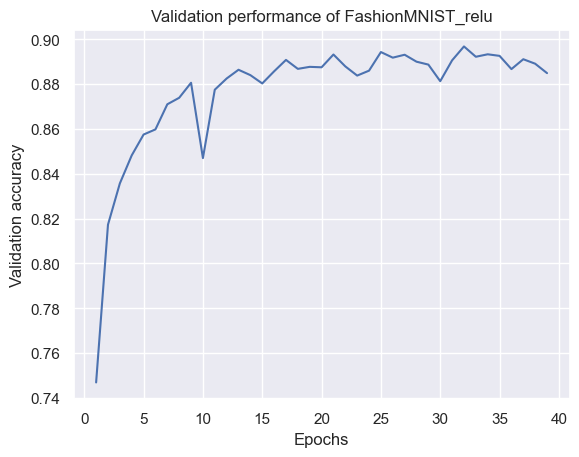

============= Test accuracy: 89.02% ==============

Model file exists, but will be overwritten...


Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  1] Training accuracy: 82.84%, Validation accuracy: 85.40%
	   (New best performance, saving model...)


Epoch 2:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  2] Training accuracy: 87.62%, Validation accuracy: 87.22%
	   (New best performance, saving model...)


Epoch 3:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  3] Training accuracy: 89.18%, Validation accuracy: 86.51%


Epoch 4:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  4] Training accuracy: 90.04%, Validation accuracy: 88.22%
	   (New best performance, saving model...)


Epoch 5:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  5] Training accuracy: 90.80%, Validation accuracy: 88.14%


Epoch 6:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  6] Training accuracy: 91.36%, Validation accuracy: 88.16%


Epoch 7:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  7] Training accuracy: 92.01%, Validation accuracy: 88.43%
	   (New best performance, saving model...)


Epoch 8:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  8] Training accuracy: 92.63%, Validation accuracy: 87.94%


Epoch 9:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch  9] Training accuracy: 92.98%, Validation accuracy: 88.37%


Epoch 10:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 10] Training accuracy: 93.47%, Validation accuracy: 88.49%
	   (New best performance, saving model...)


Epoch 11:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 11] Training accuracy: 93.81%, Validation accuracy: 88.52%
	   (New best performance, saving model...)


Epoch 12:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 12] Training accuracy: 94.47%, Validation accuracy: 88.87%
	   (New best performance, saving model...)


Epoch 13:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 13] Training accuracy: 94.86%, Validation accuracy: 88.90%
	   (New best performance, saving model...)


Epoch 14:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 14] Training accuracy: 95.08%, Validation accuracy: 88.83%


Epoch 15:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 15] Training accuracy: 95.43%, Validation accuracy: 88.91%
	   (New best performance, saving model...)


Epoch 16:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 16] Training accuracy: 95.57%, Validation accuracy: 89.02%
	   (New best performance, saving model...)


Epoch 17:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 17] Training accuracy: 96.15%, Validation accuracy: 88.57%


Epoch 18:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 18] Training accuracy: 96.18%, Validation accuracy: 88.82%


Epoch 19:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 19] Training accuracy: 96.45%, Validation accuracy: 88.52%


Epoch 20:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 20] Training accuracy: 96.50%, Validation accuracy: 88.42%


Epoch 21:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 21] Training accuracy: 96.84%, Validation accuracy: 88.55%


Epoch 22:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 22] Training accuracy: 97.17%, Validation accuracy: 88.55%


Epoch 23:   0%|          | 0/195 [00:00<?, ?it/s]

[Epoch 23] Training accuracy: 97.46%, Validation accuracy: 88.69%
Early stopping due to no improvement over the last 7 epochs


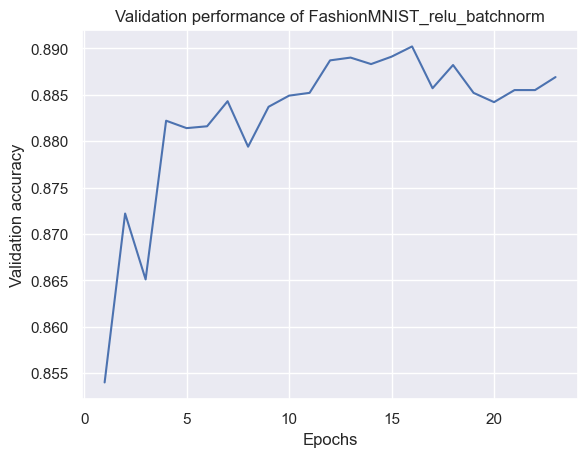

============= Test accuracy: 89.04% ==============



In [34]:
set_seed(42)
act_fn = act_fn_by_name['relu']()
networks = {'FashionMNIST_relu' : BaseNetwork(act_fn = act_fn).to(device), 
            'FashionMNIST_relu_batchnorm': BaseNetworkNorm(act_fn=act_fn).to(device)}
for name, network in networks.items():
    train_model(network, name, overwrite=True)

By comparing the validation accuracy at epoch 5, we can see we've got a higher accuracy with batch normalisation than without, and the final test accuracy for both models is equivalent.

## Early stopping

You will have briefly seen this earlier in the training code for our models with different activation functions; one way we can stop a neural network from overfitting is through **early stopping**. 

In other words, we monitor the training and validation loss, and simply stop training if the validation loss hasn't improved enough. Generally speaking, we require the validation loss must improve at minimum every `patience` epochs, i.e. if the validation hasn't improved in `patience` epochs then we stop training.

If when you train for a given number of epochs you see your validation performance stops improving while your training performance continues to improve, it's a good idea to include early stopping.

For an example, see the earlier training loop code.

## Learning rate scheduling

Choosing the learning rate is important, and not always simple. In fact, we may find that we want our learning rate to change as we train, so once we approach the minimum of our loss function we take smaller steps. This is done through **learning rate scheduling**.

By including learning rate scheduling, we can specify how or when we want our learning rate to change. Some examples include:

* Constant decrease in LR every $N$ epochs

* Exponential decrease in LR every epoch

* Reduce learning rate by same value when performance stops improving

There are of course as many ways of varying your learning rate as you can think of. There are a number available in PyTorch, available under `torch.optim.lr_scheduler`. The code cell below shows a short example of how we might include a learning rate scheduler in our training loop:

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import TensorDataset, DataLoader

n_samples = 50
n_features = 3
n_classes = 5

X, y = torch.randn([n_samples, n_features]), torch.randint(0,n_classes, n_samples)
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size = 10)

in_channels = n_features
hidden_channels = 20
out_channels = n_classes

model = nn.Sequential([nn.Linear(in_channels, hidden_channels),
                       nn.ReLU(),
                       nn.Linear(hidden_channels, out_channels)])

optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
scheduler = ExponentialLR(optimizer, gamma = 0.9)
loss_fcn = nn.CrossEntropyLoss()

for epoch in range(10):
    for input, target in dataloader:
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fcn(output, target)
        loss.backward()
        optimizer.step()
    scheduler.step()

We can see from this code a few things:

* A learning rate scheduler connects directly to an optimizer

* The learning rate scheduler must step like the optimizer, but after all optimizer steps for the epoch have been done

You can read more about learning rate schedulers for PyTorch in [the documentation](https://docs.pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate). These can be useful if you find your training loss has stopped improving but your overall performance still isn't good enough, and you are not overfitting.

<hr style="border:2px solid gray">

# Conclusion [^](#index) <a id='conclusion'></a>

In this notebook, we have reviewed a set of six activation functions in neural networks (sigmoid, tanh, ReLU, LeakyReLU, ELU, and Swish), and discussed how they influence the gradient distribution across layers.

Sigmoid tends to fail in deep neural networks since the highest gradient it provides is 0.25. This leads to vanishing gradients in early layers. 

All ReLU-based activation functions performed well and, besides the original ReLU, do not have the issue of dead neurons. 

When implementing your own neural network, it is recommended to start with a ReLU-based network and select the specific activation function based on the properties of the network.

<hr style="border:2px solid gray">
<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

# Appendix <a id='appendix'></a>

[Return to Index](#index)

In this section, you will find longer pieces of mathematics and code which are **non-examinable**. Please read at your own discretion

- A. [Backpropagation with Matrices](#matrix_app)
- B. [Cross-Entropy](#cross)
- C. [Activation Functions Overview](#act_fn_app)

<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

## A. Backpropagation with Matrices [^^](#appendix) <a id='matrix_app'></a>
    
[Return to Gradient Flow](#gradient-flow) 
    
_References: Machine Learning Mastery: [A Gentle Introduction to the Jacobian](https://machinelearningmastery.com/a-gentle-introduction-to-the-jacobian/), PyTorch: [A Gentle Introduction to torch.autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)_
    
We will use the previously considered backward() function to briefly examine how to use matrices for the chain rule.

In most instances, we will call backward() on your loss function in order to calculate the gradients required for optimisation. 

In this section, we will consider how autograd behaves if **v** is the gradient of some **scalar** function $l$: $v = \nabla l(\boldsymbol{y})$, with grad calculated with respect to **y**. Therefore:

\begin{equation}
    J^T \cdot \boldsymbol{v} =
                            \begin{bmatrix} 
                                \frac{\partial y_1}{\partial x_1} & \dots  & \frac{\partial y_m}{\partial x_1}\\
                                      \vdots & \ddots & \vdots\\
                                \frac{\partial y_1}{\partial x_n} & \dots  & \frac{\partial y_m}{\partial x_n} 
                            \end{bmatrix}
    \begin{pmatrix}  
          \frac{\partial l}{\partial y_1} \\ \vdots \\  \frac{\partial l}{\partial y_m}
    \end{pmatrix}  = 
                    \begin{pmatrix}  
                        \frac{\partial l}{\partial x_1} \\ \vdots \\  \frac{\partial l}{\partial x_m} 
                    \end{pmatrix}
\end{equation}

This means that for a loss function $l$, we can calculate all the partial derivatives with respect to the elements of **x** (which could be the weights, the biases etc) by calculating the Jacobian of **y** wrt **x**, and having previously calculated how $l$ depends on **y**. We can then use this differential to calculate the next gradient, and so on - this is a key principle of backpropagation. If **v** contained only ones, as we saw previously, this would mean that a change to any element in **y** would have an equal impact on the loss function - this is why described this ones tensor as having _equal gradient flow_.




<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

## B. Cross-Entropy [^^](#appendix) <a id='cross'></a>

[Return to Gradient Flow](#gradient-flow)   

Cross-Entropy is a commonly used loss function for classification problems.

### Binary Cross-Entropy/Log Loss

If we have a binary classification problem, the cross entropy loss function is **the same** as that of the log loss. 

When this type of model makes a prediction about a data instance's classification, it is actually calculating the **probability** of the instance belonging to each category, and assigning it to the category where the probability is greatest. We use this probability value in our loss function calculations.

Imagine we assign a label, $y_i$, to our data points such that belonging to the category has a label value of 1, and not belonging has a label value of 0. The model's predicted probability of a data point belonging to the category is given by $p(x_i)$.

The formula for log loss is given by:

\begin{equation}
    H = - \frac{1}{N} \sum_{i=1}^N y_i \cdot \log( p(x_i)) + (1 - y_i) \cdot \log(1 - p(x_i))
\end{equation}

The label $y_i$ can only be 0 or 1, so for each instance only one of the log probability terms will be included in the sum. Also note that since this a binary classification problem, 1 - p(x_i) is the model's predicted probability that the instance is not in the category.

-log(a) tends to infinity as a tends to 0, and -log(1) = 0. Therefore worse prediction values will contribute a larger amount to the loss function, and more accurate predictions will contribute amounts closer to 0. This is what we require for a loss function.

### More categories

It is easier to work with a binary model than when there are multiple outputs. Thus we choose to convert a multiple category model to a binary type. 

Let there be m possible categories for our dataset to fall into. We now give each data instance m labels, where the label $y_i^{(k)}$ is 1 or 0 depending on whether the instance is in the $k^{th}$ category or not. The categories are discrete, so only one label value will be non-zero. This data engineering method is called **one-hot encoding**. $p_k(x_i)$ denotes the model's predicted probability of the data instance belonging to category k.

To calculate the cross-entropy, we can then simply sum over each respective category:

\begin{equation}
    H = - \frac{1}{N} \sum_{j=1}^m \sum_{i=1}^N y_i^{(m)} \cdot \log( p_k(x_i)) + (1 - y_i^{(m)})) \cdot \log(1 - p_k(x_i))
\end{equation}
### Connection to Entropy

If you have previously studied thermodynamics or information theory, you will be able to see why this loss function is related to **entropy**. For example, consider the similarities of the loss function to the equation for Gibbs entropy: $S_G = -\sum p_i \log(p_i)$, where $p_i$ is the probability of the system being in a given microstate.

_References: Medium: Daniel Godoy - [Understanding binary cross-entopy/log loss](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a), Medium: Vlastimil Martinek - [Cross-entropy for Classification](https://towardsdatascience.com/cross-entropy-for-classification-d98e7f974451)._

<div style="background-color:#efdff2">

## C. Activation Functions Overview [^^](#appendix) <a id='act_fn_app'></a>

 
### Sigmoid

The sigmoid function has the form: $$f(x) = \frac{1}{1+e^{-x}} = \frac{e^x}{e^x + 1}$$


### Tanh

The tanh function has the form: 
    
$$ f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

### ReLU

ReLU stands for "Rectified Linear Unit", and has the form: 
    
$$ f(x) = \max(0,x) =  \begin{cases}
x, & x > 0 \\
0, & x \leq 0
\end{cases}$$
    
### Leaky ReLU

The Leaky ReLU function had the form: 
    
$$ f(x) =  \begin{cases}
  x, & x > 0 \\
  ax, & x \leq 0
 \end{cases}, \textrm{ } (a<1).$$
 
 
### ELU

ELU stands for "Exponential Linear Unit". Notice that when $\alpha=0$, it reduces to the ReLU function. ELU has the form:
    
$$ f(x) = \begin{cases}
  x, & x > 0 \\
  \alpha(e^x-1), & x \leq 0
 \end{cases}$$
    

 
 
### Swish

The Swish function is the sigmoid function multipied by $x$. It has the form:
$$f(x) = \frac{x}{1+e^{-x}}$$

## References

[1] Ramachandran, Prajit, Barret Zoph, and Quoc V. Le. "Searching for activation functions." arXiv preprint arXiv:1710.05941 (2017). [Paper link](https://arxiv.org/abs/1710.05941) 